# Use Case 4: Comparing Mutation Protein Abundance

<b>Standard imports for playing with and plotting data frames.</b>

In [3]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

<b>Import CPTAC data</b>

In [4]:
import CPTAC

Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Data...

 ******PLEASE READ******


In [5]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

### Test for protein levels (mutation in a gene with protein levels of any protein)
<b>Note:</b> You can put any number of proteins in the list and it will compare that gene with the protein levels of all of them

In [6]:
gene = 'CTNNB1'
protList = ['APC']

pcutoff = 0.05/len(protList)

genedf = somatic_mutations[gene].to_frame()
for protein in protList:
    if protein in proteomics.columns:
        proteindf = proteomics[protein].to_frame()
        proteindfName = protein + " protein"
        proteindf.columns = [proteindfName]
        cross = genedf.add(proteindf, fill_value=0).dropna(axis=0)
        mutated = cross.loc[cross[gene] == 1.0]
        wt = cross.loc[cross[gene] == 0.0]
        ttest = scipy.stats.ttest_ind(mutated[proteindfName], wt[proteindfName])
        print("Test for " + protein + ": ")
        print(ttest)

Test for APC: 
Ttest_indResult(statistic=2.3788061421962734, pvalue=0.019306819408921982)


<b>Boxplot (should be ready to go right after running the above cell)</b>

[Text(0,0.5,'Proteomics'), Text(0.5,0,'Somatic Gene Mutation')]

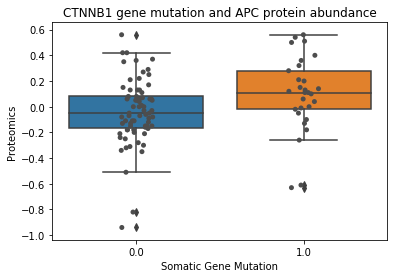

In [7]:
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=proteindfName)
somatic_boxplot.set_title(gene + " gene mutation and " + protList[0] + " protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=proteindfName,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")

### Test for phosphorylation levels (mutation in a gene with phosphorylation of any protein)

In [11]:
gene = 'CTNNB1'
sites = phos.filter(regex='CTNNB')
sigResults = [];

genedf = somatic_mutations[gene].to_frame()
cross = genedf.add(sites, fill_value=0)
mutated = cross.loc[cross[gene] == 1.0]
wt = cross.loc[cross[gene] == 0.0]

#pcutoff = 0.05/len(cross.columns)
pcutoff = 1

for loc in cross.columns:
    if not loc == gene:
        mutsitedf = mutated[[gene, loc]].dropna()
        wtsitedf = wt[[gene, loc]].dropna()
        ttest = scipy.stats.ttest_ind(mutsitedf[loc], wtsitedf[loc])
        if ttest[1] <= pcutoff:
            sigResults.append(loc)
            print('Results for ' + loc + ': ')
            print(ttest)

Results for CTNNB1-S191: 
Ttest_indResult(statistic=2.2692264290923103, pvalue=0.02544664965354751)
Results for CTNNB1-S552: 
Ttest_indResult(statistic=2.163602875652791, pvalue=0.0329258305710386)
Results for CTNNBL1-S545: 
Ttest_indResult(statistic=1.2275642887021105, pvalue=0.2227422886211706)


[Text(0,0.5,'Phosphoproteomics'), Text(0.5,0,'Somatic Gene Mutation')]

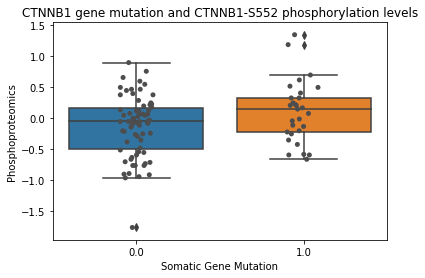

In [14]:
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=sigResults[1])
somatic_boxplot.set_title(gene + " gene mutation and " + sigResults[1] + " phosphorylation levels")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=sigResults[1],jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

### Test for phosphorylation levels and protein abundance

In [ ]:
phosProt = phos.filter(regex='FGFR') 
protein = 'STAT1'

proteindf = proteomics[protein].to_frame()
cross = proteindf.add(phosProt, fill_value=0)

pcutoff = 0.05/len(cross.columns)
print(pcutoff)

for loc in cross.columns:
    if not loc == protein:
        oneSitedf = cross[[loc, protein]].dropna(axis=0)
        pearsonresult = pearsonr(oneSitedf[loc], oneSitedf[protein])
        print("Results for " + loc)
        print(pearsonresult)

<b>Plot of the data. You'll have to enter the phosphorylation site and protein you want</b>

In [ ]:
alt.Chart(cross).mark_point().encode(
    alt.X('FGFR1OP-S160', type='quantitative', axis=alt.Axis(title="Phosphorylation at FGFR1OP")),
    alt.Y('STAT1', type='quantitative', axis=alt.Axis(title="STAT1 Protein Abundance"))
).interactive()